In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')


In [4]:

# Download necessary resources
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)


True

In [5]:

# Load the dataset
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [6]:

# Analyze the dataset
print("Dataset Head:")
print(df.head())


Dataset Head:
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


In [7]:

# Check for duplicates and remove them
duplicate_rows = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicate_rows)}")
df = df.drop_duplicates() 



Number of duplicate rows: 0


In [8]:

# Check for null values
print("\nNull values count:")
print(df.isnull().sum())



Null values count:
Review    0
Rating    0
dtype: int64


In [9]:

print(f"\nDataset shape: {df.shape}")



Dataset shape: (20491, 2)


In [10]:

# Function to categorize sentiment
def categorize_sentiment(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating==3:
        return 'Neutral'
    elif rating in [1, 2]:
        return 'Negative'


In [11]:

# Apply function to 'Rating' column and create new 'Sentiment' column
df['Sentiment'] = df['Rating'].apply(categorize_sentiment)
# Keep only review text and sentiment columns
df = df.loc[:, ['Review', 'Sentiment']]
print("\nDataset with sentiment:")
print(df.head())



Dataset with sentiment:
                                              Review Sentiment
0  nice hotel expensive parking got good deal sta...  Positive
1  ok nothing special charge diamond member hilto...  Negative
2  nice rooms not 4* experience hotel monaco seat...   Neutral
3  unique, great stay, wonderful time hotel monac...  Positive
4  great stay great stay, went seahawk game aweso...  Positive


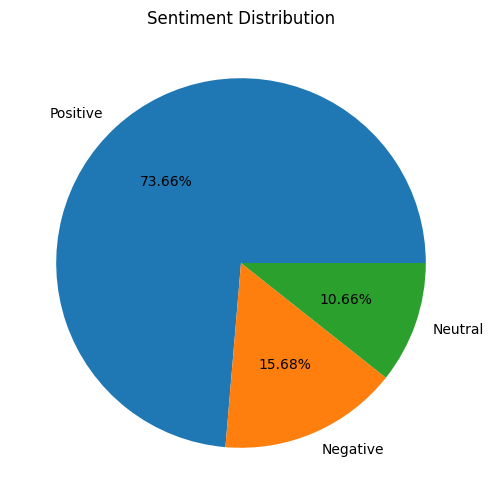

In [12]:

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
df["Sentiment"].value_counts().plot(kind="pie", autopct="%0.2f%%")
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()


In [13]:



X = df['Review']
y = df['Sentiment']


In [14]:

# Improved text preprocessing
def clean_text(text):
    """
    Clean and normalize text data:
    1. Remove HTML tags
    2. Remove special characters
    3. Convert to lowercase
    4. Remove extra whitespace
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove non-alphanumeric characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Stopwords and Lemmatizer setup
stop_words = set(stopwords.words('english'))
domain_stopwords = {'hotel', 'room', 'stay', 'night', 'day', 'days', 'stayed', 'property', 'resort', 'location', 'time'}
stop_words.update(domain_stopwords)
lemmatizer = WordNetLemmatizer()

def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def preprocess_text(text):
    """
    Advanced text preprocessing:
    1. Clean text
    2. Tokenize
    3. POS tagging
    4. Lemmatize with POS
    5. Remove stopwords and short words
    """
    # Clean text first
    text = clean_text(text)
    
    # Tokenize
    word_tokens = word_tokenize(text)
    
    # POS tagging
    pos_tags = pos_tag(word_tokens)
    
    # Filter out stopwords and lemmatize based on POS
    tokens = []
    for word, tag in pos_tags:
        if word not in stop_words and len(word) > 2:  # Skip short words
            wordnet_pos = get_pos(tag)
            lemma = lemmatizer.lemmatize(word, wordnet_pos)
            tokens.append(lemma)
    
    return tokens, ' '.join(tokens) if tokens else ""

print("\nProcessing text data...")
tokenized_corpus = []  # List of lists of tokens
processed_texts = []   # List of processed text strings

for review in X:
    tokens, processed_text = preprocess_text(review)
    tokenized_corpus.append(tokens)
    processed_texts.append(processed_text)



Processing text data...


In [15]:

# Encode sentiment labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nEncoded sentiment classes: {label_encoder.classes_}")



Encoded sentiment classes: ['Negative' 'Neutral' 'Positive']


In [16]:

# Create vocabulary from tokens
print("\nBuilding vocabulary...")
all_tokens = []
for tokens in tokenized_corpus:
    all_tokens.extend(tokens)

# Get unique tokens with count >= 5
token_counts = {}
for token in all_tokens:
    token_counts[token] = token_counts.get(token, 0) + 1

# Only keep tokens that appear at least 5 times
vocab = {token for token, count in token_counts.items() if count >= 5}

# Create word-to-index mapping (vocabulary)
word_to_index = {word: i+1 for i, word in enumerate(vocab)}  # Reserve 0 for padding
vocab_size = len(word_to_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")



Building vocabulary...
Vocabulary size: 12412


In [17]:

# Set parameters for embedding and sequences
sent_length = 150  # Sentence length for padding
embedding_dim = 500  # Dimension of word vectors


In [18]:

# Convert texts to sequences
def texts_to_sequences(tokenized_texts, word_to_index, max_length):
    sequences = []
    for tokens in tokenized_texts:
        # Convert tokens to indices, using 0 if token not in vocabulary
        sequence = [word_to_index.get(token, 0) for token in tokens]
        sequences.append(sequence)
    
    # Pad sequences to the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
    return padded_sequences


In [19]:

# Convert corpus to sequences
print("\nConverting text to sequences...")
X_sequences = texts_to_sequences(tokenized_corpus, word_to_index, sent_length)
print(f"Sequences shape: {X_sequences.shape}")



Converting text to sequences...
Sequences shape: (20491, 150)


In [20]:

# Convert to numpy arrays
X_final = np.array(X_sequences)


In [21]:

# Since we have binary sentiment, we can use binary encoding
if len(np.unique(y_encoded)) == 2:
    print("Binary sentiment classification detected")
    y_final = y_encoded  # For binary classification
else:
    # Convert target to one-hot encoding (for categorical_crossentropy)
    num_classes = len(np.unique(y_encoded))
    y_final = to_categorical(y_encoded, num_classes=num_classes)
    print(f"Multi-class classification with {num_classes} classes")


Multi-class classification with 3 classes


In [22]:

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training shapes: X: {X_train.shape}, y: {len(y_train) if len(y_encoded) == 2 else y_train.shape}")
print(f"Testing shapes: X: {X_test.shape}, y: {len(y_test) if len(y_encoded) == 2 else y_test.shape}")


Training shapes: X: (16392, 150), y: (16392, 3)
Testing shapes: X: (4099, 150), y: (4099, 3)


In [24]:

# Define model parameters
print("\nBuilding LSTM model with Embedding layer...")

# Build the model with trainable embedding layer
model = Sequential([
    # Embedding layer - now trainable
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sent_length,
        mask_zero=True,
        embeddings_regularizer=l2(0.0001)
    ),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(
        128,
        kernel_regularizer=l2(0.0001),
        recurrent_regularizer=l2(0.0001),
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2
    )),
    
    # Regularization layers
    BatchNormalization(),
    Dropout(0.7),
    
    # Dense hidden layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    # Output layer - adjusted based on binary vs multi-class
    Dense(1 if len(np.unique(y_encoded)) == 2 else len(np.unique(y_encoded)), 
          activation='sigmoid' if len(np.unique(y_encoded)) == 2 else 'softmax')
])

# Compile model with appropriate settings
if len(np.unique(y_encoded)) == 2:
    loss_function = 'binary_crossentropy'
else:
    loss_function = 'categorical_crossentropy'

model.compile(
    loss=loss_function,
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

print(model.summary())

# Set up callbacks for better training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=5,
    factor=0.5,
    verbose=1,
    min_lr=0.00001
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)



Building LSTM model with Embedding layer...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

Training the model...
Epoch 1/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 216s 412ms/step - accuracy: 0.3475 - loss: 1.8911 - val_accuracy: 0.7736 - val_loss: 1.1792 - learning_rate: 1.0000e-04
Epoch 2/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 205s 400ms/step - accuracy: 0.7057 - loss: 1.1464 - val_accuracy: 0.8365 - val_loss: 0.8670 - learning_rate: 1.0000e-04
Epoch 3/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 234s 456ms/step - accuracy: 0.8163 - loss: 0.9026 - val_accuracy: 0.8295 - val_loss: 0.8374 - learning_rate: 1.0000e-04
Epoch 4/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 292s 570ms/step - accuracy: 0.8379 - loss: 0.8115 - val_accuracy: 0.8441 - val_loss: 0.7816 - learning_rate: 1.0000e-04
Epoch 5/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 281s 548ms/step - accuracy: 0.8599 - loss: 0.7416 - val_accuracy: 0.8395 - val_loss: 0.7715 - learning_rate: 1.0000e-04
Epoch 6/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 207s 404ms/step - accuracy: 0.8656 - loss: 0.6841 - val_accuracy: 0.8307 - val_loss: 0.7691 - learning_rate: 1.0000e-04
Epoch 7/15
5

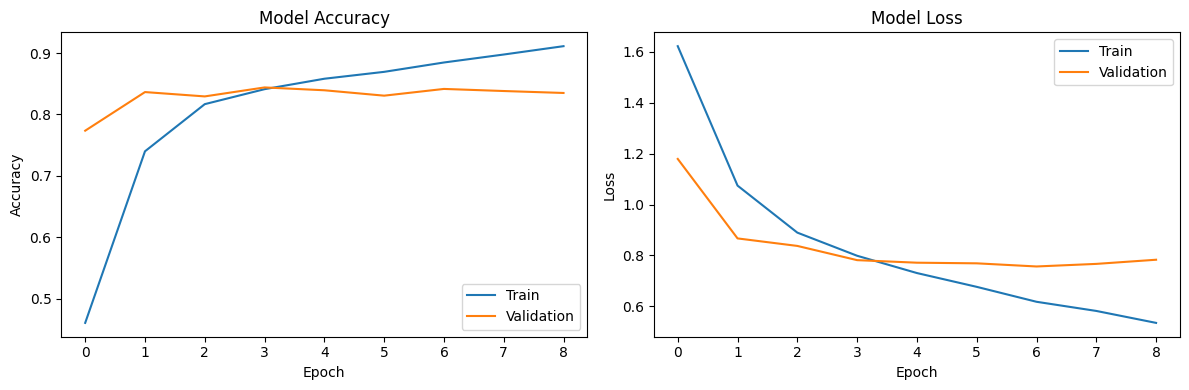

In [27]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [28]:

# Evaluate the model
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test)



Evaluating model on test data...
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8439 - loss: 0.7806
Test Loss: 0.7816
Test Accuracy: 0.8441
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


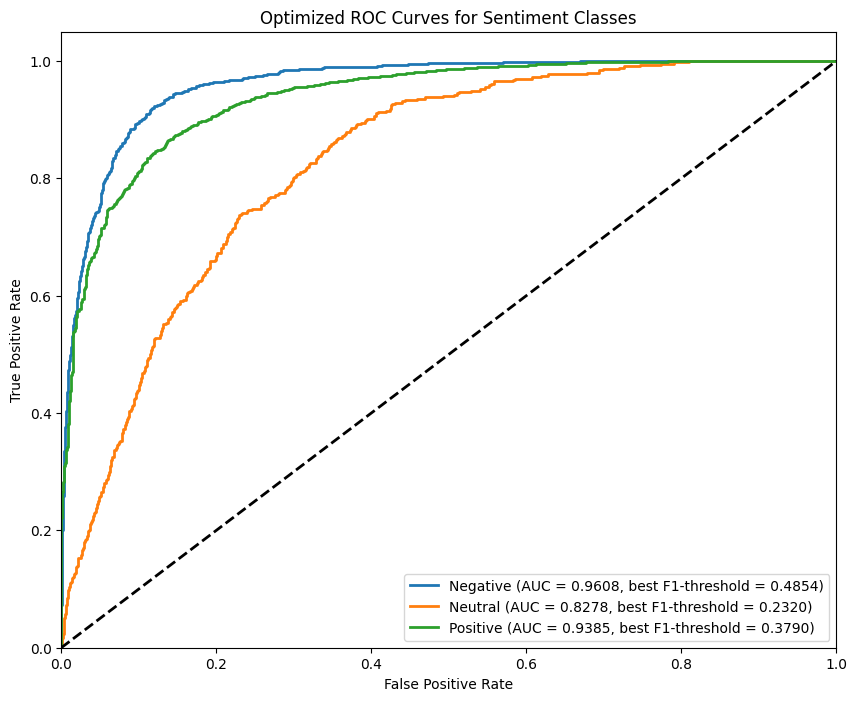

Optimized thresholds for each class (based on F1-score):
Negative: 0.4854
Neutral: 0.2320
Positive: 0.3790


In [37]:
from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

optimal_thresholds = {}
n_classes = len(label_encoder.classes_)

# Convert y_test to one-hot encoding for ROC analysis if not already
if len(y_test.shape) == 1:
    y_test_onehot = to_categorical(y_test, num_classes=n_classes)
else:
    y_test_onehot = y_test  # Already in one-hot format

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, thresholds = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Youden’s J statistic (TPR - FPR)
    youden_idx = np.argmax(tpr - fpr)
    youden_threshold = thresholds[youden_idx]

    # Find optimal F1-score threshold
    best_f1 = 0
    best_f1_threshold = youden_threshold  # Default to Youden’s if no better F1-score is found
    for threshold in thresholds:
        y_pred_bin = (y_pred_prob[:, i] >= threshold).astype(int)
        f1 = f1_score(y_test_onehot[:, i], y_pred_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_f1_threshold = threshold

    # Choose best threshold based on max(F1-score)
    optimal_thresholds[class_name] = best_f1_threshold

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.4f}, best F1-threshold = {best_f1_threshold:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized ROC Curves for Sentiment Classes')
plt.legend(loc="lower right")
plt.show()

print("Optimized thresholds for each class (based on F1-score):")
for class_name, threshold in optimal_thresholds.items():
    print(f"{class_name}: {threshold:.4f}")


In [38]:
# Define the updated prediction function
def predict_sentiment(new_reviews):
    """
    Predict sentiment for new reviews with optimized thresholds for multiclass classification
    """
    # Process the reviews
    tokenized_reviews = []
    for review in new_reviews:
        tokens, _ = preprocess_text(review)
        tokenized_reviews.append(tokens)
    
    # Convert to sequences
    sequences = texts_to_sequences(tokenized_reviews, word_to_index, sent_length)
    
    # Get raw probability predictions
    pred_probs = model.predict(sequences)
    
    # Initialize array for calibrated predictions
    calibrated_preds = np.zeros_like(pred_probs)
    
    # Apply class-specific thresholds
    for i, class_name in enumerate(label_encoder.classes_):
        calibrated_preds[:, i] = pred_probs[:, i] >= optimal_thresholds[class_name]
    
    # For samples where no class exceeds threshold, pick highest probability
    no_class_samples = np.sum(calibrated_preds, axis=1) == 0
    if np.any(no_class_samples):
        highest_prob_classes = np.argmax(pred_probs[no_class_samples], axis=1)
        for i, sample_idx in enumerate(np.where(no_class_samples)[0]):
            calibrated_preds[sample_idx, highest_prob_classes[i]] = 1
    
    # For samples with multiple classes above threshold, keep only the highest probability
    multi_class_samples = np.sum(calibrated_preds, axis=1) > 1
    if np.any(multi_class_samples):
        highest_prob_classes = np.argmax(pred_probs[multi_class_samples], axis=1)
        for i, sample_idx in enumerate(np.where(multi_class_samples)[0]):
            # Reset all to 0
            calibrated_preds[sample_idx] = 0
            # Set only the highest probability class to 1
            calibrated_preds[sample_idx, highest_prob_classes[i]] = 1
    
    # Convert to class indices
    pred_classes = np.argmax(calibrated_preds, axis=1)
    pred_labels = label_encoder.inverse_transform(pred_classes)
    
    return pred_labels, pred_probs

In [ ]:

# Example usage with hotel-specific reviews
print("\nTesting prediction with optimized thresholds:")
sample_reviews = [
    "The hotel was absolutely fantastic! The rooms were clean and spacious, and the staff was incredibly helpful.",
    "We had a terrible experience at this hotel. The room was dirty, and the service was extremely slow.",
    "The location was perfect and the view was amazing, but the breakfast was disappointing and the wifi didn't work properly.",
    "the rooms were awesome.",
    "met expectations centrally located hotel blocks water popular nightlife shopping options belltown downtown, classify property star location, paid wedding rate not sure fares value proposition, room spacious little outdated, rooms decent views lower floor drab panaroma parking lot buildings, adequate fitness center sauna pool basement quaint bar/restaurant attached hotel, parking 30 day outrage possibly standard downtown street parking weekend save dollars, willing stay future price significantly lower nearby four-star competition",
    "pay read reviews booked knew getting, mind n't surprised, fact better expected, yes rooms outdated towels floormat limited cable tv overall lack amenities use hotel, reviewer said like budget overseas hotel stayed similar condition just enjoyed experience, check desk service great, asked extra pillows maid got, spent 5 flowers pike street added character room.location, friends stayed fairmont street stayed 3 nights night cost, money went dinners trip victoria baseball games"
]

predictions, probabilities = predict_sentiment(sample_reviews)

for i, (review, sentiment) in enumerate(zip(sample_reviews, predictions)):
    print(f"Review: {review[:50]}..." if len(review) > 50 else f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    
    # For multiclass, show all probabilities
    class_probs = ", ".join([f"{cls}: {prob:.4f}" for cls, prob in zip(label_encoder.classes_, probabilities[i])])
    print(f"Probabilities: {class_probs}")
    print()



Testing prediction with optimized thresholds:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Review: The hotel was absolutely fantastic! The rooms were...
Predicted Sentiment: Positive
Probabilities: Negative: 0.0055, Neutral: 0.0144, Positive: 0.9801

Review: We had a terrible experience at this hotel. The ro...
Predicted Sentiment: Negative
Probabilities: Negative: 0.9371, Neutral: 0.0492, Positive: 0.0137

Review: The location was perfect and the view was amazing,...
Predicted Sentiment: Positive
Probabilities: Negative: 0.3461, Neutral: 0.0708, Positive: 0.5831

Review: the rooms were awesome.
Predicted Sentiment: Positive
Probabilities: Negative: 0.2274, Neutral: 0.2229, Positive: 0.5497

Review: met expectations centrally located hotel blocks wa...
Predicted Sentiment: Neutral
Probabilities: Negative: 0.2119, Neutral: 0.4358, Positive: 0.3523

Review: pay read reviews booked knew getting, mind n't sur...
Predicted Sentiment: Neutral
Probabilities: Negative: 0.3506, Neutral: 0.2762, Positive: 0.3732

Model and preprocessing components saved successfully!


In [ ]:

# Save the model and preprocessing components
model.save("imdb_sentiment_model.h5")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(word_to_index, "word_to_index.pkl")

# Save parameters as dictionary
model_params = {
    "sent_length": sent_length,
    "embedding_dim": embedding_dim,
    "vocab_size": vocab_size,
    "multiclass_thresholds": optimal_thresholds
}

joblib.dump(model_params, "model_params.pkl")

# Save optimized thresholds separately for easy access
joblib.dump(optimal_thresholds, "optimal_thresholds.pkl")

print("Model and preprocessing components saved successfully!")
